In [38]:
# IMPORTS
import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
#import pytorch_lightning as pl

# TODO remove
DATA_DIR = 'C:/Users/kajin/Documents/_/3/ZMO/sm/archiven/'
RESULTS_TRAIN_DIR = DATA_DIR+'Results/Results_Training/'
NUM_SEGMENTS = 500
NUM_IMAGES = 369
NUM_FEATURES = 2+10

# LOAD FEATURES
def get_features(features_dir, num_segments):
    X = np.zeros([NUM_IMAGES, num_segments, NUM_FEATURES])
    y = np.zeros([NUM_IMAGES, num_segments])
    num = 0
    i = 0
    for file in os.listdir(features_dir):
        if 'means_a' in file:
            X[num, :, 0] = np.load((features_dir+file), allow_pickle=True)
            i += 1
        elif 'stds_a' in file:
            X[num, :, 1] = np.load((features_dir+file), allow_pickle=True)
            i += 1
        elif 'histograms_a' in file:
            X[num, :, 2:NUM_FEATURES] = np.transpose(np.load((features_dir+file), allow_pickle=True)) # TODO transpose check
            i += 1
        elif 'labels_a' in file:
            y[num, :] = np.squeeze(np.load((features_dir+file)))
            i += 1

        if i == 4:
            num += 1
            i = 0

    X = X.reshape((NUM_IMAGES * num_segments, NUM_FEATURES))
    y = y.reshape((NUM_IMAGES * num_segments,))

    # exclude mixed superpixels
    good = np.where(y != 0.5)[0]
    X = X[good, :]
    y = y[good]
    
    # exclude background
    foreground = np.where(X[:,1] > 1.)[0]
    X = X[foreground, :]
    y = y[foreground]

    # TODO remove
    # random shuffle data
    r = np.array(range(X.shape[0]))
    np.random.shuffle(r)
    X = X[r, :]
    y = y[r]
    
    # select smaller dataset
    size = X.shape[0]
    X = X[:size, :]
    y = y[:size]
    
    # print
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    print(X.shape, y.shape)
    print(len(pos), len(neg))
    
    # calculate weights
    w_pos = (1. / len(pos)) * (size / 2)
    w_neg = (1. / len(neg)) * (size / 2)
    weights = np.empty(size)
    weights[pos] = w_pos
    weights[neg] = w_neg

    return X, y, weights


class Data(Dataset):
    def __init__(self, X, y, weights):
        assert X.shape[0] == y.shape[0] ==  len(weights)
        self.len = X.shape[0]
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.weights = torch.from_numpy(weights.astype(np.float32))

    def __getitem__(self, index):
        return self.X[index, :], self.y[index], self.weights[index]

    def __len__(self):
        return self.len

# # TODO remove
# X, y = get_features(RESULTS_TRAIN_DIR, NUM_SEGMENTS)
# print(X.dtype)
# print(np.shape(X))

# CLASSIFICATION
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() #NeuralNetwork, self
        hidden_dim = 20

        self.lin1 = nn.Linear(NUM_FEATURES, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = torch.nn.functional.sigmoid(x)
        return x


In [39]:
model = NeuralNetwork()

X, y, weights = get_features(RESULTS_TRAIN_DIR, NUM_SEGMENTS)
train_data = Data(X, y, weights)
    
num_epochs = 200 #TODO
batch_size = X.shape[0]
loss_values = []

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

(61451, 12) (61451,)
1137 60314


# Train NN on all images (without cross-validation)

In [40]:
X_tens = torch.from_numpy(X.astype(np.float32))
y_tens = torch.from_numpy(y.astype(np.float32))
weights_tens = torch.from_numpy(weights.astype(np.float32))
loss_values = []
for epoch in range(num_epochs):
    print("epoch ", epoch)
    for X_, y_, weights_ in train_dataloader:
        pred = model(X_).squeeze()
        loss = nn.BCELoss(weight=weights_)(pred, y_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        pred = model(X_tens).squeeze()
        loss = nn.BCELoss(weight=weights_tens)(pred, y_tens)
        loss_values.append(loss.item())

print("Training Completed")

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11


KeyboardInterrupt: 

In [36]:
train_data.y = np.array(train_data.y)
with torch.no_grad():
    
    outputs = model(train_data.X).squeeze()
    outputs = np.array(outputs)
    
    # count statistics
    predictions = np.where(outputs < 0.5, 0, 1)
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    correct_pos = np.sum(predictions[pos] == train_data.y[pos])
    correct_neg = np.sum(predictions[neg] == train_data.y[neg])
    
    total = train_data.y.shape[0]
    correct = np.sum(predictions == train_data.y)
    accuracy = correct / total
    
    found_tumors = correct_pos / len(pos)
    misslab_nontumors = 1-(correct_neg / len(neg))

    print(f"true labels: 1/all: {np.sum(train_data.y == 1) / train_data.y.shape[0]}")
    print(f"positive predictions: {np.sum(predictions != 0)}")
    print(f'Accuracy: {accuracy}')
    print()
    print(f'Found tumors (%): {found_tumors}')
    print(f'Misslabeled non-tumors (%): {misslab_nontumors}')
    print(f"len(pos): {len(pos)}")
    print(f"len(neg): {len(neg)}")

true labels: 1/all: 0.018502546744560706
positive predictions: 61351
Accuracy: 0.019902035768335748

Found tumors (%): 0.9938434476693052
Misslabeled non-tumors (%): 0.9984580694366151
len(pos): 1137
len(neg): 60314


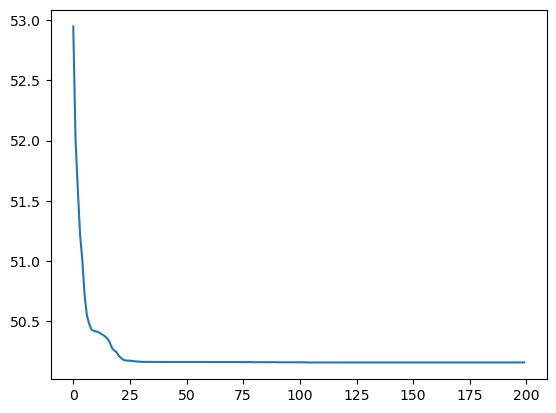

In [37]:
import matplotlib.pyplot as plt
plt.plot(loss_values)
# print(loss_values)

# Display one image and the classification from NN

In [75]:
from preprocessing import *
import matplotlib.pyplot as plt
TRAIN_DIR = DATA_DIR+'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

IMAGE_COUNT = 1
VERSION = 'b'

count = 0
num_segments = 500

X = np.zeros([num_segments, NUM_FEATURES])
y = np.zeros([num_segments])
for (dirpath, dirnames, filenames) in os.walk(TRAIN_DIR):
    for dir in dirnames:

        ### LOAD DATA ###
        img_, mask_ = load_data(dirpath, dir)
        superpixels_ = np.load(RESULTS_TRAIN_DIR+dir+'_superpixels_'+VERSION+'.npy', allow_pickle=True)
        means_ = np.load(RESULTS_TRAIN_DIR+dir+'_means_'+VERSION+'.npy', allow_pickle=True)
        stds_ = np.load(RESULTS_TRAIN_DIR+dir+'_stds_'+VERSION+'.npy', allow_pickle=True)
        histograms_ = np.load(RESULTS_TRAIN_DIR+dir+'_histograms_'+VERSION+'.npy', allow_pickle=True)
        labels_ = np.load(RESULTS_TRAIN_DIR+dir+'_labels_'+VERSION+'.npy', allow_pickle=True)
        
        X[:, 0] = means_
        X[:, 1] = stds_
        X[:, 2:NUM_FEATURES] = np.transpose(histograms_)
        y = labels_
        
        count += 1
        print(count)
        if count == IMAGE_COUNT:
            break
    if count == IMAGE_COUNT:
        break


1


In [1]:
#X = torch.from_numpy(X.astype(np.float32))
y_tens = torch.from_numpy(y.astype(np.float32))
with torch.no_grad():
    outputs = model(torch.from_numpy(X.astype(np.float32))).squeeze()
    predictions = torch.where(outputs < 0.5, 0, 1)
    total = y.shape[0]
    correct = torch.where((predictions == y_tens) == True)
    correct = len(correct)
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    correct_pos = torch.where((predictions[pos] == y_tens[pos]) == True)
    correct_neg = torch.where((predictions[neg] == y_tens[neg]) == True)
    correct_pos = len(correct_pos)
    correct_neg = len(correct_neg)

#print(correct_neg)
#print(len(predictions))
print(correct_pos)
print(correct_neg)
print(correct)
print(y_tens == 1)
#print(correct)

print(f"true labels: 1/all: {torch.sum(y_tens == 1) / y.shape[0]}")
print(f"positive predictions: {torch.sum(predictions != 0)}")
print(f'Accuracy: {correct / total}')
print()
print(f'Found tumors (%): {correct_pos / len(pos)}')
print(f'Misslabeled non-tumors (%): {1. - (correct_neg / len(neg))}')
print(f"len(pos): {len(pos)}")
print(f"len(neg): {len(neg)}")

NameError: name 'torch' is not defined

# Cross validaton, all images

fold 1
true labels: 1/all: 0.014138607388035306
positive predictions: 11743
Accuracy: 0.04870872834259562

Found tumors (%): 0.7976878612716763
Misslabeled non-tumors (%): 0.9620326618585758
len(pos): 173
len(neg): 12063
fold 2
true labels: 1/all: 0.014792415822164106
positive predictions: 8295
Accuracy: 0.31072245831971235

Found tumors (%): 0.11602209944751381
Misslabeled non-tumors (%): 0.6863542098714226
len(pos): 181
len(neg): 12055
fold 3
true labels: 1/all: 0.013157894736842105
positive predictions: 10353
Accuracy: 0.14906832298136646

Found tumors (%): 0.3167701863354037
Misslabeled non-tumors (%): 0.853167701863354
len(pos): 161
len(neg): 12075
fold 4
true labels: 1/all: 0.014793624846751124
positive predictions: 9343
Accuracy: 0.24037597057621576

Found tumors (%): 0.6353591160220995
Misslabeled non-tumors (%): 0.7655550024888004
len(pos): 181
len(neg): 12054
fold 5
true labels: 1/all: 0.013731099305271761
positive predictions: 7052
Accuracy: 0.41593788312219043

Found tumors

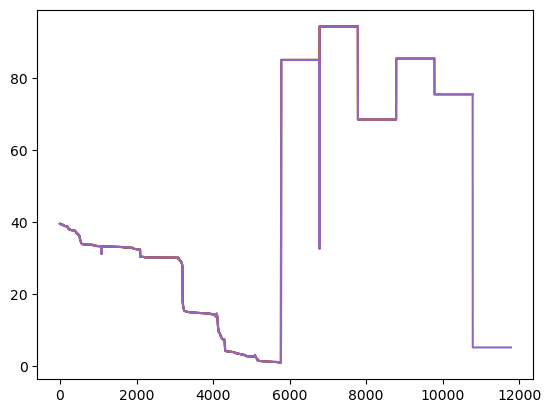

In [31]:
# CROSS VALIDATION

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

DATA_DIR = 'C:/Users/kajin/Documents/_/3/ZMO/sm/archiven/'
RESULTS_NN = DATA_DIR+'Results/Results_NN/'
VERSION = 'b'
NN_SPEC = '_1'

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print("fold", fold+1)
    model = NeuralNetwork()
    model.train()
    
    X_train, X_val = X[train_idx,:], X[val_idx,:]
    y_train, y_val = y[train_idx], y[val_idx]

    train_data = Data(X_train, y_train, weights)
    val_data = Data(X_val, y_val, weights)

    train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        #print("epoch ", epoch)
        for X_, y_, weights_ in train_dataloader:
            pred = model(X_).squeeze()
            loss = nn.BCELoss(weight=weights_)(pred, y_)
            loss_values.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                 
    model.eval()
    accuracy = np.zeros(folds,)
    found_tumors = np.zeros(folds,)
    misslab_nontumors = np.zeros(folds,)
    val_data.y = np.array(val_data.y)
    with torch.no_grad():
        outputs = model(val_data.X).squeeze()
        outputs = np.array(outputs)
        
        # count statistics
        predictions = np.where(outputs < 0.5, 0, 1)
        pos = np.where(y_val == 1)[0]
        neg = np.where(y_val == 0)[0]
        correct_pos = np.sum(predictions[pos] == val_data.y[pos])
        correct_neg = np.sum(predictions[neg] == val_data.y[neg])
        
        total = val_data.y.shape[0]
        correct = np.sum(predictions == val_data.y)
        accuracy[fold] = correct / total
        
        found_tumors[fold] = correct_pos / len(pos)
        misslab_nontumors[fold] = 1-(correct_neg / len(neg))

    np.save(os.path.join(RESULTS_NN, 'NN_outputs_'+str(fold)+VERSION+NN_SPEC), outputs)
        
    print(f"true labels: 1/all: {np.sum(val_data.y == 1) / val_data.y.shape[0]}")
    print(f"positive predictions: {np.sum(predictions != 0)}")
    print(f'Accuracy: {accuracy[fold]}')
    print()
    print(f'Found tumors (%): {found_tumors[fold]}')
    print(f'Misslabeled non-tumors (%): {misslab_nontumors[fold]}')
    print(f"len(pos): {len(pos)}")
    print(f"len(neg): {len(neg)}")
    
    plt.plot(loss_values)
    
np.save(os.path.join(RESULTS_NN, 'found_tumors_'+VERSION+NN_SPEC), found_tumors)
np.save(os.path.join(RESULTS_NN, 'misslabeled_nontumors_'+VERSION+NN_SPEC), misslab_nontumors)

In [30]:

VERSION = 'b'
np.save(os.path.join(RESULTS_NN, 'NN_outputs_'+str(fold)+'_'+VERSION+NN_SPEC), outputs)

In [32]:
train_data.y = np.array(train_data.y)
with torch.no_grad():
    
    outputs = model(train_data.X).squeeze()
    outputs = np.array(outputs)
    
    # count statistics
    predictions = np.where(outputs < 0.5, 0, 1)
    pos = np.where(y_train == 1)[0]
    neg = np.where(y_train == 0)[0]
    correct_pos = np.sum(predictions[pos] == train_data.y[pos])
    correct_neg = np.sum(predictions[neg] == train_data.y[neg])
    
    total = train_data.y.shape[0]
    correct = np.sum(predictions == train_data.y)
    accuracy = correct / total
    
    found_tumors = correct_pos / len(pos)
    misslab_nontumors = 1-(correct_neg / len(neg))

    print(f"true labels: 1/all: {np.sum(train_data.y == 1) / train_data.y.shape[0]}")
    print(f"positive predictions: {np.sum(predictions != 0)}")
    print(f'Accuracy: {accuracy}')
    print()
    print(f'Found tumors (%): {found_tumors}')
    print(f'Misslabeled non-tumors (%): {misslab_nontumors}')
    print(f"len(pos): {len(pos)}")
    print(f"len(neg): {len(neg)}")

true labels: 1/all: 0.014220623991173405
positive predictions: 28432
Accuracy: 0.41164211429622216

Found tumors (%): 0.23850574712643677
Misslabeled non-tumors (%): 0.5858602607416006
len(pos): 696
len(neg): 48247


# Display one picture - not from NN

In [ ]:


from preprocessing import *
import matplotlib.pyplot as plt
TRAIN_DIR = DATA_DIR+'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

IMAGE_COUNT = 1
VERSION = 'b'

count = 0
for (dirpath, dirnames, filenames) in os.walk(TRAIN_DIR):
    for dir in dirnames:

        ### LOAD DATA ###
        img_, mask_ = load_data(dirpath, dir)
        superpixels_ = np.load(RESULTS_TRAIN_DIR+dir+'_superpixels_'+VERSION+'.npy', allow_pickle=True)
        tumor_labels = np.load(RESULTS_TRAIN_DIR+dir+'_labels_'+VERSION+'.npy', allow_pickle=True)
        
        count += 1
        print(count)
        if count == IMAGE_COUNT:
            break
    if count == IMAGE_COUNT:
        break


In [64]:
tumor_pixels = np.zeros((NUM_SEGMENTS, 2))
for (x,y,z), label in np.ndenumerate(superpixels_):
    if mask_[x,y,z] > 0.:
        tumor_pixels[label,0] += 1
    else:
        tumor_pixels[label,1] += 1

low, mid, high = [], [], []

for i in range(NUM_SEGMENTS):
    ratio = tumor_pixels[i,0] / np.sum(tumor_pixels[i,:])
    if ratio > 0.8:
        high.append(i)
 

C:\Users\kajin\AppData\Local\Temp\ipykernel_25092\919076732.py:11: RuntimeWarning: invalid value encountered in scalar divide
  ratio = tumor_pixels[i,0] / np.sum(tumor_pixels[i,:])


In [65]:
print(len(high))

9


[0. 1. 2. 4.]


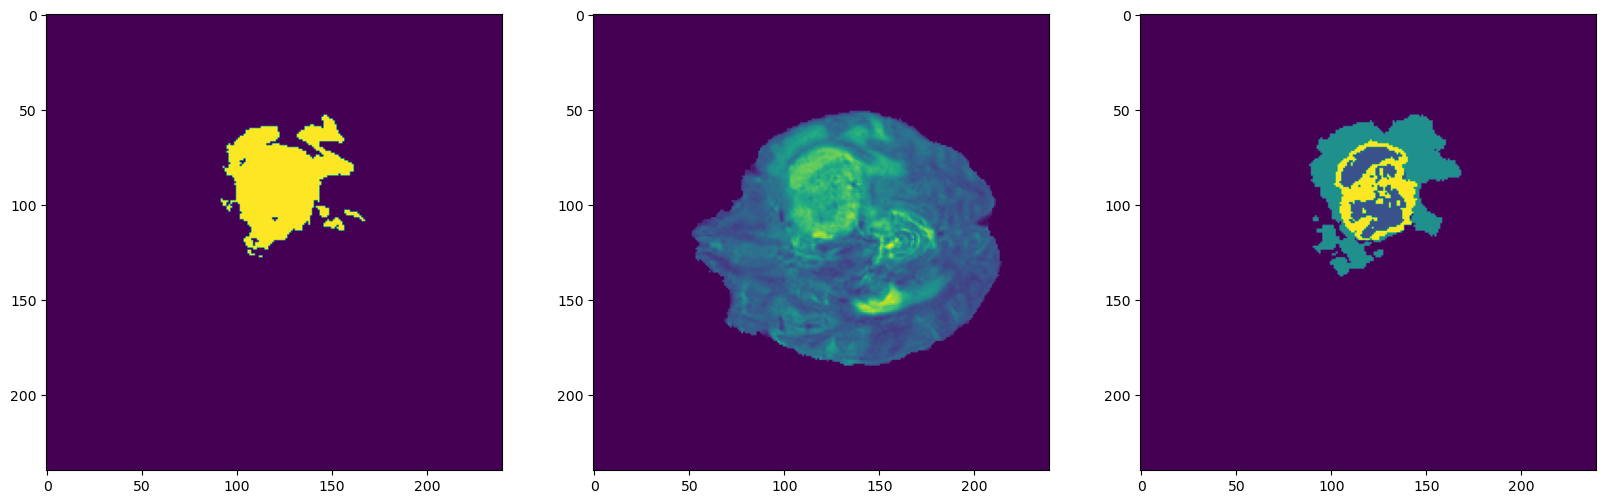

In [72]:
im = np.zeros_like(img_[:,:,:])
im[superpixels_ == (high[0])] = 1.
im[superpixels_ == (high[1])] = 1.
im[superpixels_ == (high[2])] = 1.
im[superpixels_ == (high[3])] = 1.
im[superpixels_ == (high[4])] = 1.
im[superpixels_ == (high[5])] = 1.
im[superpixels_ == (high[6])] = 1.
im[superpixels_ == (high[7])] = 1.
im[superpixels_ == (high[8])] = 1.

print(np.unique(mask_))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 10))
ax1.imshow(im[:,:,60])
ax2.imshow(img_[:,:,60])
ax3.imshow(mask_[:,:,60])

1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 